<h1> Inspect super-resolved images </h1>

For each method:
for each dataset: (cerrado, uc merced, oli2msi, sent nicfi)
- get best method
- load trained weights
- predict 5 images
- save images


In [1]:


DATADIR="/home/s1620444/data1/data"
DATASETSDIR="/home/s1620444/data1/data/tfds"
RESULTSDIR="/home/s1620444/data1/results"
WEIGHTSDIR="/home/s1620444/data1/results/weights"
PLOTSDIR="/home/s1620444/data1/plots"
PROJECTDIR="/data1/s1620444/automl-sr-rs/autoSR"

import os
os.environ["DATASETSDIR"]=DATASETSDIR
os.environ["RESULTSDIR"]=RESULTSDIR
os.environ["DATADIR"]=DATADIR

import sys
sys.path.append(PROJECTDIR)

from baselines.rcan.rcan import generator as rcan
from baselines.wdsr.wdsr import wdsr_b
from auto_models.models.autosrcnn import autoSRCNN
from auto_models.models.autosr_rs import autoSR_RS
from utils import get_test_set, psnr,ssim
from PIL import Image,ImageEnhance
import matplotlib.pyplot as plt
import numpy as np
import pickle
from utils import resolve

2022-06-14 15:09:00.119723: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
def load_model(model_name,scale,dataset,trained_weights_dir):
    dataset_options=["cerrado","sr_ucmerced","sr_so2sat","oli2msi"]
    if model_name=="wdsr":
        model=wdsr_b(scale, num_res_blocks=32)
        model.load_weights(trained_weights_dir)
        return model

    elif model_name=="rcan":
        model=rcan(scale=scale)
        model.load_weights(trained_weights_dir)
        return model
    
    elif model_name=="autosrcnn":
        return autoSRCNN(trained_weights_dir, f"0_simple_srcnn_{dataset}", max_trials=20, scale=scale, overwrite=False)

    elif model_name=="autosr_rs":
        if dataset in dataset_options:
            dataset_options.remove(dataset)
        return autoSR_RS(dataset_options,trained_weights_dir,f"0_autosr_v1_{dataset}", "v1",max_trials=20, scale=scale, overwrite=False)

In [2]:
dataset_sizes = {"cerrado": int(1311*0.2), "sr_ucmerced": int(2056*0.2), "sent_nicfi":int(12000*0.2), "oli2msi":int(5325*0.2)}
datasets=["cerrado", "sr_ucmerced", "oli2msi", "sent_nicfi"]
trained_weights={"rcan":{"cerrado":f"{RESULTSDIR}/weights/rcan-cerrado-x2-0/rcan-03-20-00:11/final_model.h5",
                            "sr_ucmerced":f"{RESULTSDIR}/weights/rcan-sr_ucmerced-x2-0/rcan-03-22-19:03/final_model.h5",
                            "sent_nicfi":f"{RESULTSDIR}/weights/rcan-sent_nicfi-x2-0/final_model.h5",
                            "oli2msi":f"{RESULTSDIR}/weights/rcan-oli2msi-x3-0/rcan-03-22-11:35/final_model.h5",
                            },
                    "wdsr":{"cerrado": f"{RESULTSDIR}/weights/wdsr-b-cerrado-32-x2-0/final_model.h5",
                            "sr_ucmerced": f"{RESULTSDIR}/weights/wdsr-b-sr_ucmerced-32-x2-0/final_model.h5",
                            "sent_nicfi":f"{RESULTSDIR}/weights/wdsr-b-sent_nicfi-32-x2-0/final_model.h5",
                            "oli2msi":f"{RESULTSDIR}/weights/wdsr-b-oli2msi-32-x3-0/final_model.h5"},
                    "autosrcnn":{"cerrado": f"{RESULTSDIR}/autosrcnn/",
                            "sr_ucmerced": f"{RESULTSDIR}/autosrcnn/",
                            "sent_nicfi":f"{RESULTSDIR}/autosrcnn/",
                            "oli2msi":f"{RESULTSDIR}/autosrcnn/"},
                    "autosr_rs": {"cerrado": f"{RESULTSDIR}/autosr/v1",
                            "sr_ucmerced": f"{RESULTSDIR}/autosr/v1",
                            "sent_nicfi":f"{RESULTSDIR}/autosr/v1",
                            "oli2msi":f"{RESULTSDIR}/autosr/v1"}}
methods=["autosrcnn","autosr_rs"]

<h2> Pick images </h2>

In [3]:
dataset_idx={"cerrado":[140,184,227,260,93],"sr_ucmerced":[107,12,317,395,8],"oli2msi":[327,589,712,727,789],"sent_nicfi":[158,185,2139,2274,6]}

In [7]:
for dataset in datasets:
    test_tfds=get_test_set(dataset,test_batch_size=-1, as_supervised=True)
    # this is how I originally obtained the random idx, kept them since them
    # img_idx=np.random.randint(0,dataset_sizes[dataset],size=5)
    # dataset_idx[dataset]=img_idx

    for idx in dataset_idx[dataset]:
        hr_arr=test_tfds[1][idx].numpy()
        hr=Image.fromarray(hr_arr)
        hr.save(f"{PLOTSDIR}/predicted_imgs/hr/{dataset}_{idx}.tiff")
        
        lr_arr=test_tfds[0][idx].numpy()
        lr=Image.fromarray(lr_arr)
        lr.save(f"{PLOTSDIR}/predicted_imgs/lr/{dataset}_{idx}.tiff")
    
    


In [91]:
with open(f"{PLOTSDIR}/predicted_imgs/dataset_idx.pkl","wb") as f:
        pickle.dump(dataset_idx, f)

In [6]:
def predict(model, image,method):
    if method == "autosrcnn" or method =="autosr_rs":
        sr= model.predict(image.numpy(),custom_objects={"psnr":psnr,"ssim":ssim})
        sr = np.clip(sr,0,255)
        sr = np.around(sr)
        sr=sr.astype("uint8")[0]
        return sr

    else:
        return resolve(model,image).numpy()[0]

<h2> Predict images </h2>

In [ ]:
for method in methods:
    print(f"Method: {method}")
    for dataset in datasets:
        print(f"Dataset: {dataset}")
        if dataset == "oli2msi":
            scale=3
        else:
            scale =2
            
        model=load_model(method,scale, dataset,trained_weights[method][dataset])
        test_dataset=get_test_set(dataset,test_batch_size=1,as_supervised=True)

        for i,(lr,hr) in enumerate(test_dataset):
            if i in dataset_idx[dataset]:
                sr = predict(model,lr,method)
                img= Image.fromarray(sr)
                img.save(f"{PLOTSDIR}/predicted_imgs/{method}/{dataset}_{i}.tiff")

<h2> Display images </h2>

In [12]:
def get_resampled_image(image_id,folder, new_size,dataset):
    img=Image.open(f"{PLOTSDIR}/predicted_imgs/{folder}/{image_id}")
    if dataset=="oli2msi":
        filter=ImageEnhance.Brightness(img)
        img=filter.enhance(3)
        if folder=="lr":
            img=img.crop((0,0,60,60))
        else:
            img=img.crop((0,0,180,180))
    resized_img=img.resize((new_size,new_size),Image.NEAREST)
    return resized_img

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

for dataset in ["cerrado","sr_ucmerced", "oli2msi", "sent_nicfi"]:
    # I think I want multiple grids, one per dataset.
    folder_names = {"LR":"lr","HR":"hr", "WDSR": "wdsr", "RCAN":"rcan", "AutoSRCNN":"autosrcnn","AutoSR-RS":"autosr_rs"}
    fig = plt.figure(figsize=(20., 20.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(5, 6),  # creates 5x6 grid of axes
                    axes_pad=0.1,  # pad between axes in inch.
                    share_all=True,
                    )
    grid[0].get_yaxis().set_ticks([])
    grid[0].get_xaxis().set_ticks([])

    id = 0
    
    grid[0].set_title("Original LR",size=30,weight="bold",pad=20)
    grid[1].set_title("Original HR",size=30,weight="bold",pad=20)
    grid[2].set_title("WDSR",size=30,weight="bold",pad=20)   
    grid[3].set_title("RCAN",size=30,weight="bold",pad=20)
    grid[4].set_title("AutoSRCNN",size=30,weight="bold",pad=20)
    grid[5].set_title("AutoSR-RS",size=30,weight="bold",pad=20)

    for img_id in os.listdir(f"{PLOTSDIR}/predicted_imgs/hr"):
            if dataset in img_id and img_id.endswith(".tiff"):
                hr=get_resampled_image(img_id,"hr",200,dataset)
                lr=get_resampled_image(img_id,"lr",200,dataset)

                grid[id].imshow(np.asarray(lr),interpolation="nearest", aspect="auto")
                grid[id].axis("off")

                grid[id+1].imshow(np.asarray(hr),interpolation="nearest", aspect="auto")
                grid[id+1].axis("off")
                id +=2

                for col, name in enumerate(["WDSR","RCAN", "AutoSRCNN", "AutoSR-RS"]):
                    resized_img=get_resampled_image(img_id, folder_names[name],200,dataset)

                    grid[id].imshow(np.asarray(resized_img),interpolation='nearest',aspect="auto")
                    grid[id].axis("off")
                    id+=1
    
    plt.tight_layout()
    plt.savefig(f"{PLOTSDIR}/{dataset}_sample.pdf")
    plt.show()


<h2> Images for thesis </h2>
One good, one mediocre, one bad.

Good:
sent 0
mediocre: ucmerced 2
autosrcnn sent 4
bad: cerrado 0

/home/s1620444/data1/automl-sr-rs-env/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


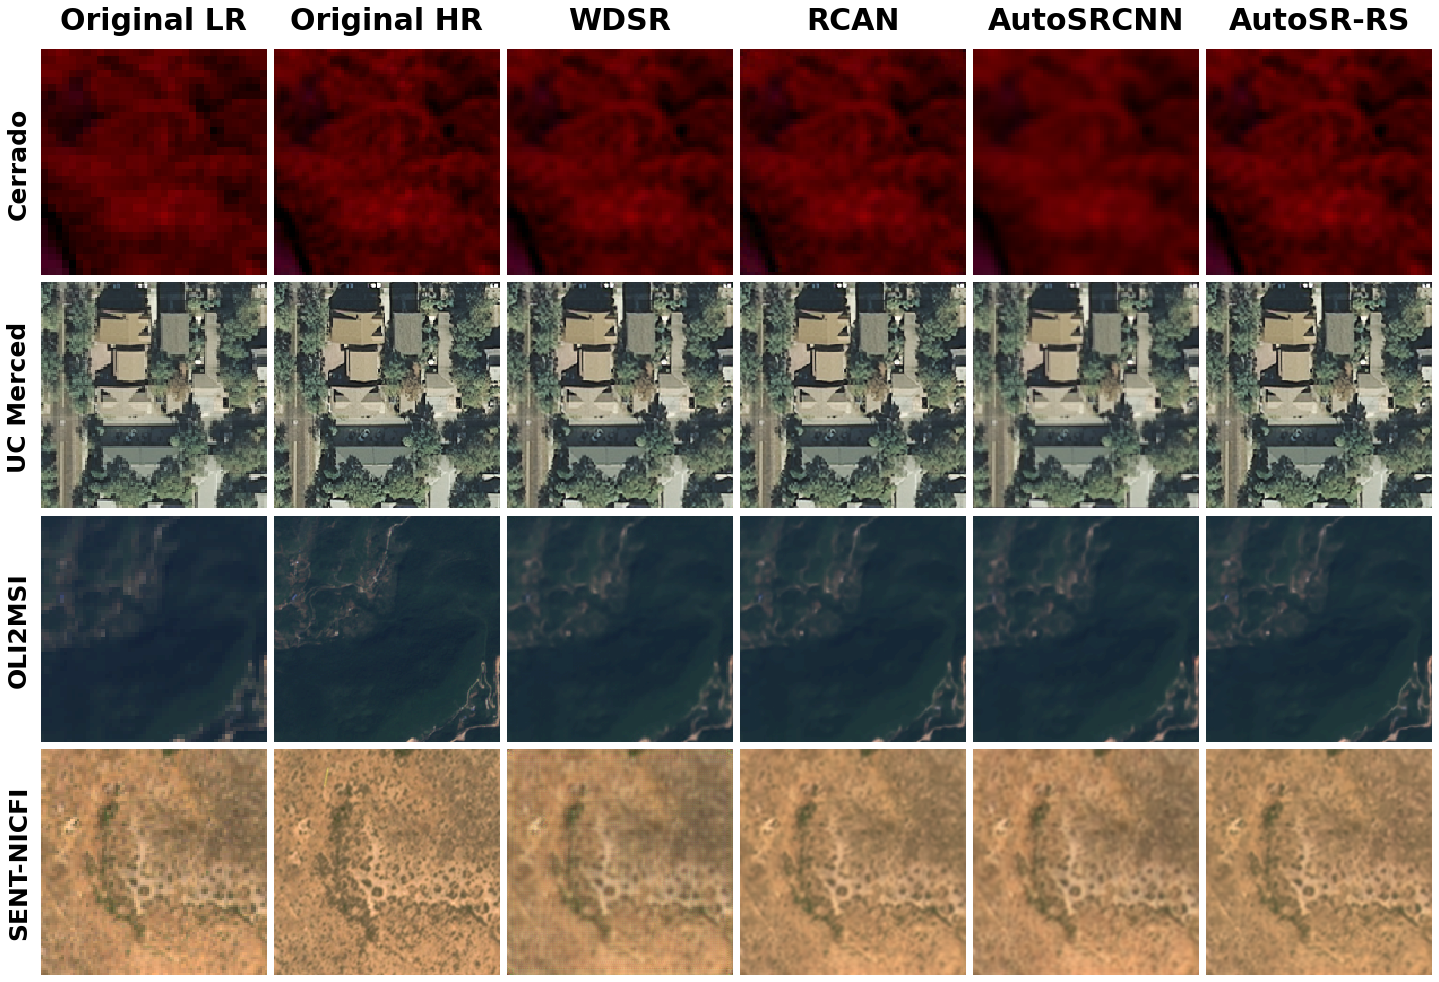

In [14]:

# I think I want multiple grids, one per dataset.
dataset_names={"sent_nicfi":"SENT-NICFI","oli2msi":"OLI2MSI","sr_ucmerced":"UC Merced","cerrado":"Cerrado"}

images=[["cerrado",0],['sr_ucmerced',0],["oli2msi",0],["sent_nicfi", 0]]

fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                nrows_ncols=(4, 6),  # creates 5x6 grid of axes
                axes_pad=0.1,  # pad between axes in inch.
                share_all=True,
                )
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])

id = 0

grid[0].set_title("Original LR",size=30,weight="bold",pad=20)
grid[1].set_title("Original HR",size=30,weight="bold",pad=20)
grid[2].set_title("WDSR",size=30,weight="bold",pad=20)   
grid[3].set_title("RCAN",size=30,weight="bold",pad=20)
grid[4].set_title("AutoSRCNN",size=30,weight="bold",pad=20)
grid[5].set_title("AutoSR-RS",size=30,weight="bold",pad=20)

for img_info in images:
    imgs=[]
    for file in os.listdir("{PLOTSDIR}/predicted_imgs/hr"):
        if img_info[0] in file:
            imgs.append(file)

    img_id=imgs[img_info[1]]

    hr=get_resampled_image(img_id,"hr",200,img_info[0])
    lr=get_resampled_image(img_id,"lr",200,img_info[0])

    grid[id].imshow(np.asarray(lr),interpolation="nearest", aspect="auto")
    grid[id].axis("off")
    grid[id].text(x = -30, y =100, s = dataset_names[img_info[0]], va = "center",rotation=90,size=25,weight="bold")

    grid[id+1].imshow(np.asarray(hr),interpolation="nearest", aspect="auto")
    grid[id+1].axis("off")
    id +=2

    for col, name in enumerate(["WDSR","RCAN", "AutoSRCNN", "AutoSR-RS"]):
        resized_img=get_resampled_image(img_id, folder_names[name],200,img_info[0])

        
        grid[id].imshow(np.asarray(resized_img),interpolation='nearest',aspect="auto")
        grid[id].axis("off")
        id+=1
    
plt.tight_layout()
plt.savefig(f"{PLOTSDIR}/predicted_images_sample.pdf")
plt.show()
